<a href="https://colab.research.google.com/github/KwonDoRyoung/AdvancedBasicEducationProgram/blob/main/python04_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
#▶︎ 오늘 강의내용
*   영상의 기하학적 변형 이해
*   잡음과 잡음제거를 위한 필터 이해
*   Image Gradient 이해
*   커널(Kernel) & 컨볼루션(Convolution) 활용한 Edge 추출
*   Gaussian Pyramid란

---
#▶︎ 먼저해야될 일: 파일 업로드 및 경로 설정
  1.   좌측 카테고리에서 파일선택
  2.   images 폴더 생성하기
  3.   "공유드라이브 >>> image04_2.zip" 압축 해제 후 생성한 폴더에 업로드 하기
  4.   폴더 경로를 받을 변수 설정하기

In [4]:
image_root_path = "/content/images"

---
##⦿   기하학적 변형 - Transformation
  -   영상 내의 객체 사이의 공간적인 관계를 변화하는 것
  -   객체를 이동하거나 크기, 모양을 변형하는 것
  -   원근변환(Projective)
    -   Affine: 선형변환과 이동변환까지 포함, 선의 수평성은 유지
        -   강체변환(Rigid-Body): 크기 및 각도 보존
            *   이동(Translation)
$$
\begin{pmatrix}1 & 0 & d_{x}\\0 & 1 & d_{y}\end{pmatrix} 
\begin{pmatrix} x \\ y \\ 1\end{pmatrix}
=\begin{pmatrix} x+d_{x} \\ y+d_{y}\end{pmatrix} 
$$
            *   회전(Rotation)
$$
\begin{pmatrix}  cosθ & sinθ & 0\\ cosθ & -sinθ & 0\end{pmatrix} 
\begin{pmatrix} x \\ y \\ 1\end{pmatrix}
=\begin{pmatrix} x * cosθ + y * sinθ \\ x * cosθ - y * sinθ \end{pmatrix} 
$$
        -   유사변환(Similarity): 각도 보존, 크기 변함 
            *   확대 및 축소(Scaling)
$$
\begin{pmatrix}s_{x} & 0 & 0\\0 & s_{y} & 0\end{pmatrix} 
\begin{pmatrix} x \\ y \\ 1\end{pmatrix}
=\begin{pmatrix} s_{x}*x \\ s_{y}*y\end{pmatrix} 
$$
        -   선형변환: Vector 공간에서의 이동, 이동변환 제외
$$
L(p+q) = L(p) + L(q)\\
L(a*p) = a*L(p)\\a:scalar
$$

    -   Perspective: Affine 변환에 수평성도 유지되지 않음. 






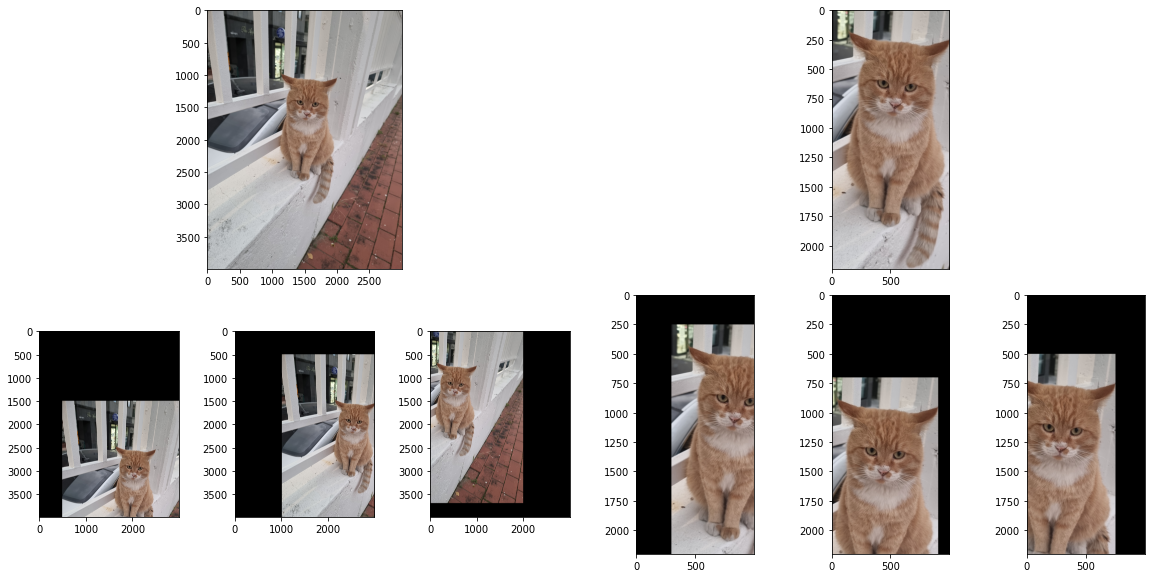

In [53]:
import os
import cv2.cv2
import numpy as np
import matplotlib.pyplot as plt

def image_translation(image, d_x, d_y):
  translation_matrix = np.array([[1, 0, d_x],[0, 1, d_y]])

  coords = np.indices((image.shape[1], image.shape[0]),).reshape(2, -1)
  coords = np.vstack((coords, np.ones(coords.shape[1])))
  
  warp_coords = (np.round(translation_matrix @ coords)).astype(np.int)
  
  x_coords, y_coords = warp_coords[0,:], warp_coords[1, :]
  indices = np.where((x_coords >=0) & (x_coords < image.shape[1]) & (y_coords >=0) & (y_coords < image.shape[0]))
  x_ori, y_ori = coords[0, :][indices].astype(np.int), coords[1, :][indices].astype(np.int)
  x_tran, y_tran = x_coords[indices], y_coords[indices]

  result_image = np.zeros_like(image)
  result_image[y_tran, x_tran] = image[y_ori, x_ori]
  return result_image

plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.1, wspace=0.4)
grid_shape=(2,6)

# =======================================================
loc=(0,0) # location(loc): 0,0
img = cv2.imread(os.path.join(image_root_path, "cat1.jpeg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot2grid(grid_shape, loc, colspan=3) # span: col 3
plt.imshow(img)

# Translation
loc=(1,0) # location(loc): 1,0
d_x = 500 # 원본 이미지(img)에서 x >> 500, y >> 1500 이동
d_y = 1500
translation_img01 = np.zeros_like(img)
translation_img01[d_y:, d_x:, :] = img[:-d_y,:-d_x,:]
plt.subplot2grid(grid_shape, loc)
plt.imshow(translation_img01)

loc=(1,1) # location(loc): 1,1
d_x = 1000
d_y = 500
translation_img02 = image_translation(img, d_x, d_y)
plt.subplot2grid(grid_shape, loc)
plt.imshow(translation_img02)

loc=(1,2) # location(loc): 1,2
d_x = -1000
d_y = -300
translation_img03 = cv2.warpAffine(img, np.array([[1, 0, d_x],[0, 1, d_y]], dtype=np.float32), (img.shape[1], img.shape[0]))
plt.subplot2grid(grid_shape, loc)
plt.imshow(translation_img03)

# =======================================================
# Cropping, 이미지가 너무 커서 자르겠습니다, numpy Slice를 활용
loc=(0,3) # location(loc): 0,3 
cat_box = [1000, 800, 2000, 3000]  # x_min, y_min, x_max, y_max
crop_img = img[cat_box[1]:cat_box[3], cat_box[0]:cat_box[2], :]  # 고양이 부분 좌표
plt.subplot2grid(grid_shape, loc, colspan=3) # span: col 3
plt.imshow(crop_img)

# Translation
loc=(1,3) # location(loc): 1,3
d_x = 300 # 원본 이미지(img)에서 x >> 500, y >> 1500 이동
d_y = 250
translation_img01 = np.zeros_like(crop_img)
translation_img01[d_y:, d_x:, :] = crop_img[:-d_y,:-d_x,:]
plt.subplot2grid(grid_shape, loc)
plt.imshow(translation_img01)

loc=(1,4) # location(loc): 1,4
d_x = -100
d_y = 700
translation_img02 = image_translation(crop_img, d_x, d_y)
plt.subplot2grid(grid_shape, loc)
plt.imshow(translation_img02)

loc=(1,5) # location(loc): 1,5
d_x = -250
d_y = 500
translation_matric = np.array([[1, 0, d_x],[0, 1, d_y]], dtype=np.float32)
translation_img03 = cv2.warpAffine(crop_img, translation_matric, (crop_img.shape[1], crop_img.shape[0]))
plt.subplot2grid(grid_shape, loc)
plt.imshow(translation_img03)

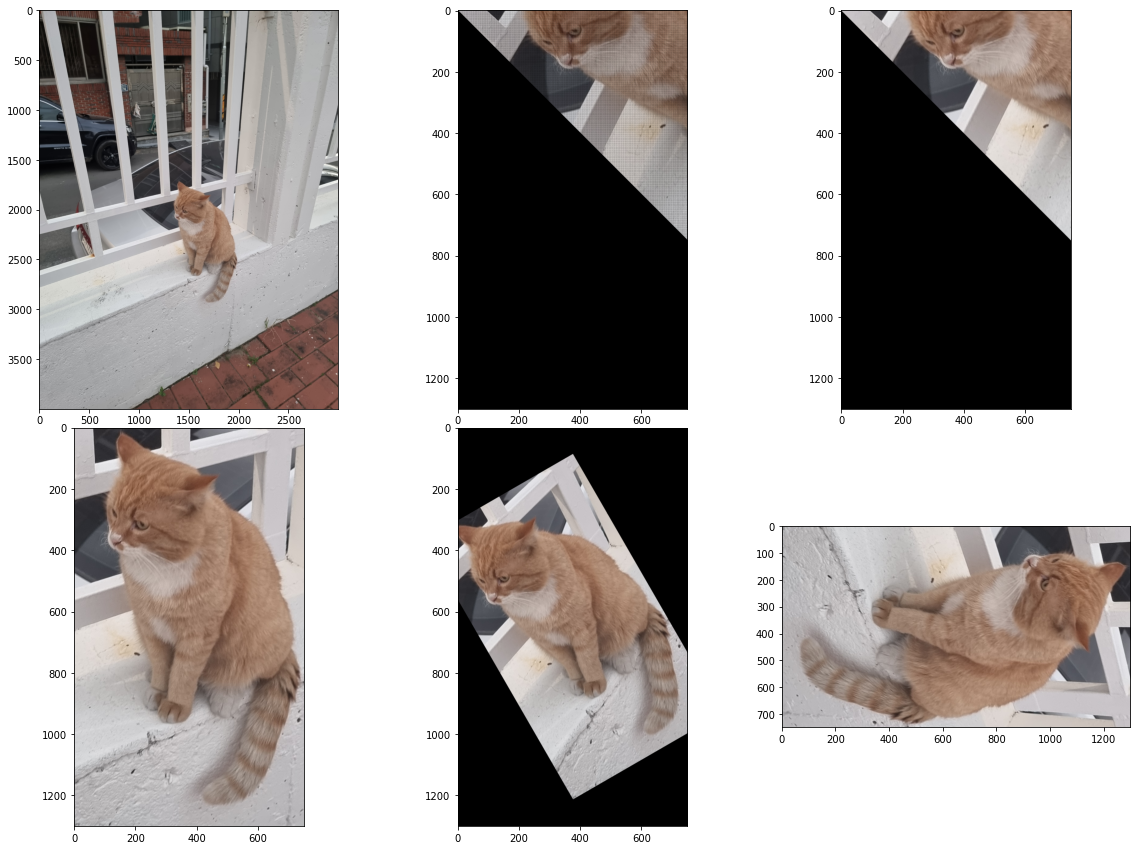

In [112]:
import os
import cv2.cv2
import numpy as np
import matplotlib.pyplot as plt

def image_rotation(image, angle):
  # 불완전 코드: 보간법이 들어가있지 않음
  radian = np.radians(angle)
  rotation_matrix = np.array([[np.cos(radian), np.sin(radian), 0],[-np.sin(radian), np.cos(radian), 0]])

  coords = np.indices((image.shape[1], image.shape[0]),).reshape(2, -1)
  coords = np.vstack((coords, np.ones(coords.shape[1])))

  warp_coords = (np.round(rotation_matrix @ coords)).astype(np.int)

  x_coords, y_coords = warp_coords[0,:], warp_coords[1, :]
  indices = np.where((x_coords >=0) & (x_coords < image.shape[1]) & (y_coords >=0) & (y_coords < image.shape[0]))
  x_ori, y_ori = coords[0, :][indices].astype(np.int), coords[1, :][indices].astype(np.int)
  x_tran, y_tran = x_coords[indices], y_coords[indices]

  result_image = np.zeros_like(image)
  result_image[y_tran, x_tran] = image[y_ori, x_ori]
  return result_image

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
grid_shape=(4,3)

# =======================================================
loc=(0,0) # location(loc)
img = cv2.imread(os.path.join(image_root_path, "cat2.jpeg"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot2grid(grid_shape, loc, rowspan=2) # span: col 2
plt.imshow(img)

# =======================================================
# Cropping, 이미지가 너무 커서 자르겠습니다, numpy Slice를 활용
loc=(2,0) # location(loc)
cat_box = [1250, 1700, 2000, 3000]  # x_min, y_min, x_max, y_max
crop_img = img[cat_box[1]:cat_box[3], cat_box[0]:cat_box[2], :]  # 고양이 부분 좌표
plt.subplot2grid(grid_shape, loc, rowspan=2) # span: row 2
plt.imshow(crop_img)

loc=(0,1)
angle = 45
rotate_img01 = image_rotation(crop_img, angle)
plt.subplot2grid(grid_shape, loc, rowspan=2)
plt.imshow(rotate_img01)

loc=(0,2)
angle = 45
radian = angle *(np.pi/180)
rotate_matric = np.array([[np.cos(radian), np.sin(radian), 0], [-np.sin(radian), np.cos(radian), 0]], dtype=np.float32)
rotate_img02 = cv2.warpAffine(crop_img, rotate_matric, (crop_img.shape[1], crop_img.shape[0]))
plt.subplot2grid(grid_shape, loc, rowspan=2)
plt.imshow(rotate_img02)

loc=(2,1)
angle = 30
center_pt = (crop_img.shape[1]//2, crop_img.shape[0]//2)
rotate_matric = cv2.getRotationMatrix2D(center_pt, angle, 0.75)
rotate_img03 = cv2.warpAffine(crop_img, rotate_matric, (crop_img.shape[1], crop_img.shape[0]))
plt.subplot2grid(grid_shape, loc, rowspan=2)
plt.imshow(rotate_img03)

loc=(2,2)
rotate_img04 = cv2.rotate(crop_img, cv2.ROTATE_90_CLOCKWISE)
plt.subplot2grid(grid_shape, loc, rowspan=2)
plt.imshow(rotate_img04)

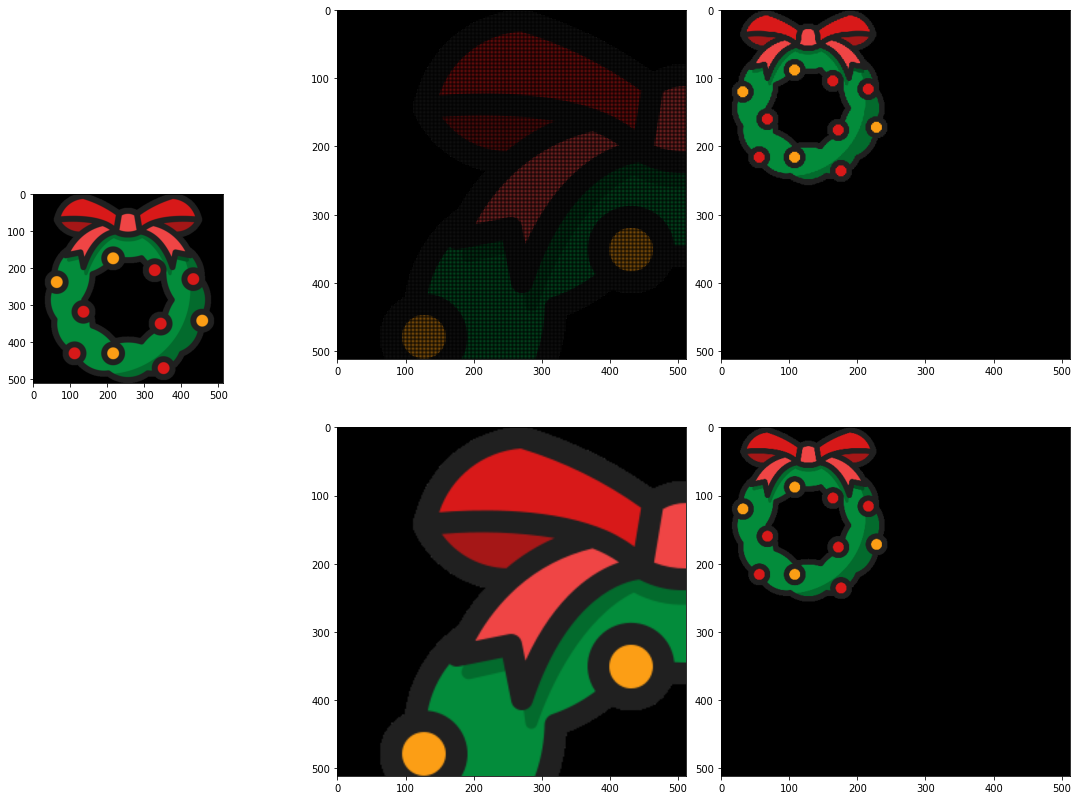

In [99]:
import os
import cv2.cv2
import numpy as np
import matplotlib.pyplot as plt

def image_scaling(image, scale):
  # 불완전 코드: 보간법이 들어가있지 않음
  scale_matrix = np.array([[scale, 0, 0],[0, scale, 0]])

  coords = np.indices((image.shape[1], image.shape[0]),).reshape(2, -1)
  coords = np.vstack((coords, np.ones(coords.shape[1])))

  warp_coords = (np.round(scale_matrix @ coords)).astype(np.int)

  x_coords, y_coords = warp_coords[0,:], warp_coords[1, :]
  indices = np.where((x_coords >=0) & (x_coords < image.shape[1]) & (y_coords >=0) & (y_coords < image.shape[0]))
  x_ori, y_ori = coords[0, :][indices].astype(np.int), coords[1, :][indices].astype(np.int)
  x_tran, y_tran = x_coords[indices], y_coords[indices]

  result_image = np.zeros_like(image)
  result_image[y_tran, x_tran] = image[y_ori, x_ori]
  return result_image

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
grid_shape=(4,3)

# =======================================================
loc=(1,0) # location(loc)
img = cv2.imread(os.path.join(image_root_path, "christmas.png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot2grid(grid_shape, loc)
plt.imshow(img)

loc=(0,1)
scale = 2.
scale_img01 = image_scaling(img, scale)
plt.subplot2grid(grid_shape, loc, rowspan=2)
plt.imshow(scale_img01)

loc=(2,1)
scale = 2.
scale_matric = np.array([[scale, 0, 0],[0, scale, 0]], dtype=np.float32)
scale_img02 = cv2.warpAffine(img, scale_matric, (img.shape[1], img.shape[0]))
plt.subplot2grid(grid_shape, loc, rowspan=2)
plt.imshow(scale_img02)

loc=(0,2)
scale = .5
scale_img03 = image_scaling(img, scale)
plt.subplot2grid(grid_shape, loc, rowspan=2)
plt.imshow(scale_img03)

loc=(2,2)
scale = .5
scale_matric = np.array([[scale, 0, 0],[0, scale, 0]], dtype=np.float32)
scale_img04 = cv2.warpAffine(img, scale_matric, (img.shape[1], img.shape[0]))
plt.subplot2grid(grid_shape, loc, rowspan=2)
plt.imshow(scale_img04)

---
##⦿   기하학적 변형 - Interpolation
  -   불연속적인 이미지(Discrete data)에서 확대와 회전은 정보 손실이 발생함
  -   정보 손실을 해결을 위해 보간법(Interpolation)을 수행해야 됨
      * 최근점 이웃 보간법(Nearest Neighbor Interpolation)
          -   이웃한 한개 픽셀의 값을 복사
      * 선형 보간법(Bilinear Interpolation)
          -   이웃한 4개 픽셀의 값을 선형 계산으로 찾아서 추가

              ```
                      (x,y)           (x+1,y)
                        *---------------*
                        |               | 
                        |   *           | 
                        | (x*,y*)       | 
                        |               |
                        *---------------*
                        (x,y+1)        (x+1,y+1)   
              ```
$$
                      f(x^{*},y^{*}) ≃ 
                      f(x,y)(1-x^{*})(1-y^{*}) + 
                      f(x+1,y)(1-y^{*})x^{*} + 
                      f(x,y+1)(1-x^{*})y^{*} +
                      f(x+1,y+1)x^{*}y^{*}
$$

512 512


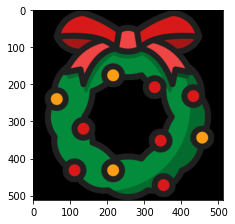

In [110]:
import os
import cv2.cv2
import numpy as np
import matplotlib.pyplot as plt

def image_rotation_v2(image, angle):
  radian = np.radians(angle)
  rotation_matrix = np.array([[np.cos(radian), np.sin(radian), 0],[-np.sin(radian), np.cos(radian), 0]])

  coords = np.indices((image.shape[1], image.shape[0]),).reshape(2, -1)
  coords = np.vstack((coords, np.ones(coords.shape[1])))

  int_warp_coords = (np.round(rotation_matrix @ coords)).astype(np.int)
  float_warp_coords = rotation_matrix @ coords

  

  



  return result_image
      


plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.1, wspace=0.1)
grid_shape=(4,3)

# =======================================================
loc=(1,0) # location(loc)
img = cv2.imread(os.path.join(image_root_path, "christmas.png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot2grid(grid_shape, loc)
plt.imshow(img)

image_rotation_v2(img, 30)

In [ ]:
#1. Nearest Neighbor

img = cv2.imread('/content/drive/My Drive/image/apple.jpg')
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

near_img = cv2.resize(img,None, fx = 10, fy = 10, interpolation = cv2.INTER_NEAREST)

#2. Bilinear interpolation

bi_img = cv2.resize(img,None, fx = 10, fy = 10, interpolation = cv2.INTER_LINEAR)

cv2_imshow(near_img)
cv2_imshow(bi_img)

---
⦿   잡음(Noise)
  -   
      * 

In [ ]:
#3. 잡음

img = cv2.imread('/content/drive/My Drive/image/Test.BMP')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#1. 잡음 예제
gau_img = cv2.imread('/content/drive/My Drive/image/gaussian.png')
gau_img = cv2.cvtColor(gau_img, cv2.COLOR_BGR2RGB)
salt_pepper_img = cv2.imread('/content/drive/My Drive/image/salt-and-pepper.png')
salt_pepper_img = cv2.cvtColor(salt_pepper_img, cv2.COLOR_BGR2RGB)


---
⦿   필터 연산(Convolution)
  -   
      * 

---
⦿   잡음(Noise) 제거와 필터 연산
  -   
      * 

In [ ]:

#2. 필터 연산: Convolution
#----------------------------------------------------#

#3. 잡음에 따른 대표 필터
#(1) 평균 필터
k_size = 10
img_aver = img.copy()
Afilter = cv2.blur(img_aver, (k_size, k_size))
gau_aver = gau_img.copy()
gAfilter = cv2.blur(gau_aver, (k_size, k_size))
sp_aver = salt_pepper_img.copy()
spAfilter = cv2.blur(sp_aver, (k_size, k_size))

def bubblesort(arr,n) :
  arrt = arr.copy()
  size = len(arrt)
  if n==0:
    for i in range(size-1):
      for j in range(size-i-1):
        if arrt[j] > arrt[j+1]:
          arrt[j], arrt[j+1] = arrt[j+1], arrt[j]
  else:
    for i in range(size-1):
      for j in range(size-i-1,0,-1):
        if arrt[j] > arrt[j-1]:
          arrt[j-1], arrt[j] = arrt[j], arrt[j-1]
      
  return arrt

#(2) 최대 필터 ---> OpenCV에 함수가 없어서 직접 구현했습니다.
def maxCon(img, n):
    img_b = img[:,:,0].copy()
    img_g = img[:,:,1].copy()
    img_r = img[:,:,2].copy()

    idx = (n*n)-1

    h = img.shape[0]-n+1
    w = img.shape[1]-n+1

    for i in range(h):
      for j in range(w):
        img_bt = img[i:i+n,j:j+n,0].reshape(-1)
        img_gt = img[i:i+n,j:j+n,1].reshape(-1)
        img_rt = img[i:i+n,j:j+n,2].reshape(-1)

        img_bt = bubblesort(img_bt,0)
        img_gt = bubblesort(img_gt,0)
        img_rt = bubblesort(img_rt,0)

        img_b[i,j] = img_bt[idx]
        img_g[i,j] = img_gt[idx]
        img_r[i,j] = img_rt[idx]

    img_c = np.dstack((img_b, img_g, img_r)).astype(np.uint8)

    return img_c 
k_size = 3
img_max = img.copy()
Maxfilter = maxCon(img_max, k_size)
gau_max = gau_img.copy()
gMaxfilter = maxCon(gau_max, k_size)
sp_max = salt_pepper_img.copy()
spMaxfilter = maxCon(sp_max, k_size)

#(3) 최소 필터 ---> OpenCV에 함수가 없어서 직접 구현했습니다.
def minCon(img, n):
    img_b = img[:,:,0].copy()
    img_g = img[:,:,1].copy()
    img_r = img[:,:,2].copy()


    h = img.shape[0]-n+1
    w = img.shape[1]-n+1 

    for i in range(h):
      for j in range(w):
        img_bt = img[i:i+n,j:j+n,0].reshape(-1)
        img_gt = img[i:i+n,j:j+n,1].reshape(-1)
        img_rt = img[i:i+n,j:j+n,2].reshape(-1)

        img_bt = bubblesort(img_bt,0)
        img_gt = bubblesort(img_gt,0)
        img_rt = bubblesort(img_rt,0)

        img_b[i,j] = img_bt[0]
        img_g[i,j] = img_gt[0]
        img_r[i,j] = img_rt[0]

    img_c = np.dstack((img_b, img_g, img_r)).astype(np.uint8)

    return img_c
k_size = 3
img_min = img.copy()
Minfilter = minCon(img_min, k_size)
gau_min = gau_img.copy()
gMinfilter = minCon(gau_min, k_size)
sp_min = salt_pepper_img.copy()
spMinfilter = minCon(sp_min, k_size)

#(4) 중간값 필터
k_size = 5
img_median = img.copy()
Mfilter = cv2.medianBlur(img_median, k_size)
gau_median = gau_img.copy()
gMfilter = cv2.medianBlur(gau_median, k_size)
sp_median = salt_pepper_img.copy()
spMfilter = cv2.medianBlur(sp_median, k_size)

plt.figure(figsize=(8,8))
plt.subplot(5,3,1)
plt.imshow(img)
plt.title('image')

plt.subplot(5,3,2)
plt.imshow(gau_img)
plt.title('Gaussian Noise')

plt.subplot(5,3,3)
plt.imshow(salt_pepper_img)
plt.title('Salt and Pepper Noise')

plt.subplot(5,3,4)
plt.imshow(Afilter)
plt.title('Average Filter')

plt.subplot(5,3,5)
plt.imshow(gAfilter)
plt.title('Gaussian Average Filter')

plt.subplot(5,3,6)
plt.imshow(spAfilter)
plt.title('Salt and Pepper Average Filter')

plt.subplot(5,3,7)
plt.imshow(Maxfilter)
plt.title('Max Filter')

plt.subplot(5,3,8)
plt.imshow(gMaxfilter)
plt.title('Gaussian Max Filter')

plt.subplot(5,3,9)
plt.imshow(spMaxfilter)
plt.title('Salt and Pepper Max Filter')

plt.subplot(5,3,10)
plt.imshow(Minfilter)
plt.title('Min Filter')

plt.subplot(5,3,11)
plt.imshow(gMinfilter)
plt.title('Gaussian Min Filter')

plt.subplot(5,3,12)
plt.imshow(spMinfilter)
plt.title('Salt and Pepper Min Filter')

plt.subplot(5,3,13)
plt.imshow(Mfilter)
plt.title('Mean Filter')

plt.subplot(5,3,14)
plt.imshow(gMfilter)
plt.title('Gaussian Mean Filter')

plt.subplot(5,3,15)
plt.imshow(spMfilter)
plt.title('Salt and Pepper Mean Filter')

plt.tight_layout()
plt.show()

In [ ]:
#4. Gaussian Blur

img = cv2.imread('/content/drive/My Drive/image/Test.BMP')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

gau_blur = cv2.GaussianBlur(img, (5,5), 0)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('image')

plt.subplot(1,2,2)
plt.imshow(gau_blur)
plt.title('Gaussian Blur')
plt.tight_layout()
plt.show()

---
⦿   Edge detection - Image Gradient
  -   
      * 

In [ ]:
#4. Edge & Kernel
#(1) Image Gradient 계산

img = cv2.imread('/content/drive/My Drive/image/Woman.bmp')
#img = cv2.GaussianBlur(img, (3,3), 0)

G_x = np.array([[-1, 0, 1]])
G_y = np.array([[-1], [0], [1]])

edge_x = cv2.filter2D(img, cv2.CV_64F, G_x)
edge_y = cv2.filter2D(img, cv2.CV_64F, G_y)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(edge_x, cmap='gray')
plt.title('edge_X')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edge_y, cmap='gray')
plt.title('edge_y')
plt.axis('off')

plt.tight_layout()
plt.show()

---
⦿   Edge Detection - 1차 미분(1st order gradient)
  -   
      * 

In [ ]:
#1. Sobel Filter

img = cv2.imread('/content/drive/My Drive/image/Woman.bmp')

sobelX = cv2.Sobel(img, -1, 1, 0, ksize=3)
sobelY = cv2.Sobel(img, -1, 0, 1, ksize=3)
sobel = sobelX + sobelY

#2. Prewitt Filter

prewittx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
prewitty = np.array([[-1, -1, -1], [0, 0, 0], [1,1,1]])
prewittc = np.array([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]])

prewittX = cv2.filter2D(img, -1, prewittx)
prewittY = cv2.filter2D(img, -1, prewitty)
prewitt_ = cv2.filter2D(img, -1, prewittc)

plt.figure(figsize=(8,8))
plt.subplot(2,3,1)
plt.imshow(sobelX)
plt.title('Sobel X Filter')

plt.subplot(2,3,2)
plt.imshow(sobelY)
plt.title('Sobel Y Filter')

plt.subplot(2,3,3)
plt.imshow(sobel)
plt.title('Sobel Filter')

plt.subplot(2,3,4)
plt.imshow(prewittX)
plt.title('Prewitt X Filter')

plt.subplot(2,3,5)
plt.imshow(prewittY)
plt.title('Prewitt Y Filter')

plt.subplot(2,3,6)
plt.imshow(prewitt_)
plt.title('Prewitt Filter')

plt.tight_layout()
plt.show()

---
⦿   Edge Detection - 2차 미분(2nd order gradient)
  -   
      * 

In [ ]:
#1. Laplacian Filter

img = cv2.imread('/content/drive/My Drive/image/Woman.bmp')

laplacian1 = cv2.Laplacian(img, -1)
laplacian2 = cv2.Laplacian(img, -1, ksize=3)

laplacian_filter1 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
laplacian_filter2 = np.array([[1,1,1], [1, -8, 1], [1,1,1]])
laplacian_4 = cv2.filter2D(img, -1, laplacian_filter1)
laplacian_8 = cv2.filter2D(img, -1, laplacian_filter2)

plt.figure(figsize=(8,8))
plt.subplot(1,4,1)
plt.imshow(laplacian1)
plt.title('Laplacian(ksize=1')

plt.subplot(1,4,2)
plt.imshow(laplacian2)
plt.title('Laplacian(ksize=2')

plt.subplot(1,4,3)
plt.imshow(laplacian_4)
plt.title('Laplacian_4')

plt.subplot(1,4,4)
plt.imshow(laplacian_8)
plt.title('Laplacian_8')

plt.tight_layout()
plt.show()

In [ ]:
#2. LoG

img = cv2.imread('/content/drive/My Drive/image/Woman.bmp')

mask3 = np.array([[-1,-1,-1], [-1, 8, -1], [-1, -1, -1]])
gaussian = cv2.GaussianBlur(img, (3,3), 0)
LoG = cv2.filter2D(gaussian, -1, mask3)

#3. DoG
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
height, width = gray.shape

gaussian1 = cv2.GaussianBlur(gray, (3,3), 1.6)
gaussian2 = cv2.GaussianBlur(gray, (3,3), 1)
DoG = np.zeros_like(gray)
for i in range(height):
  for j in range(width):
    DoG[i][j] = float(gaussian1[i][j]) - float(gaussian2[i][j])

plt.figure(figsize=(8,8))
plt.subplot(1,4,1)
plt.imshow(img)
plt.title('Original')

plt.subplot(1,4,2)
plt.imshow(gaussian)
plt.title('Gaussian Blur')

plt.subplot(1,4,3)
plt.imshow(LoG)
plt.title('LoG')

plt.subplot(1,4,4)
plt.imshow(DoG, cmap='gray')
plt.title('DoG')

plt.tight_layout()
plt.show()

---
⦿   Gaussian Pyramid
  -   
      * 

(256, 256)
(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)


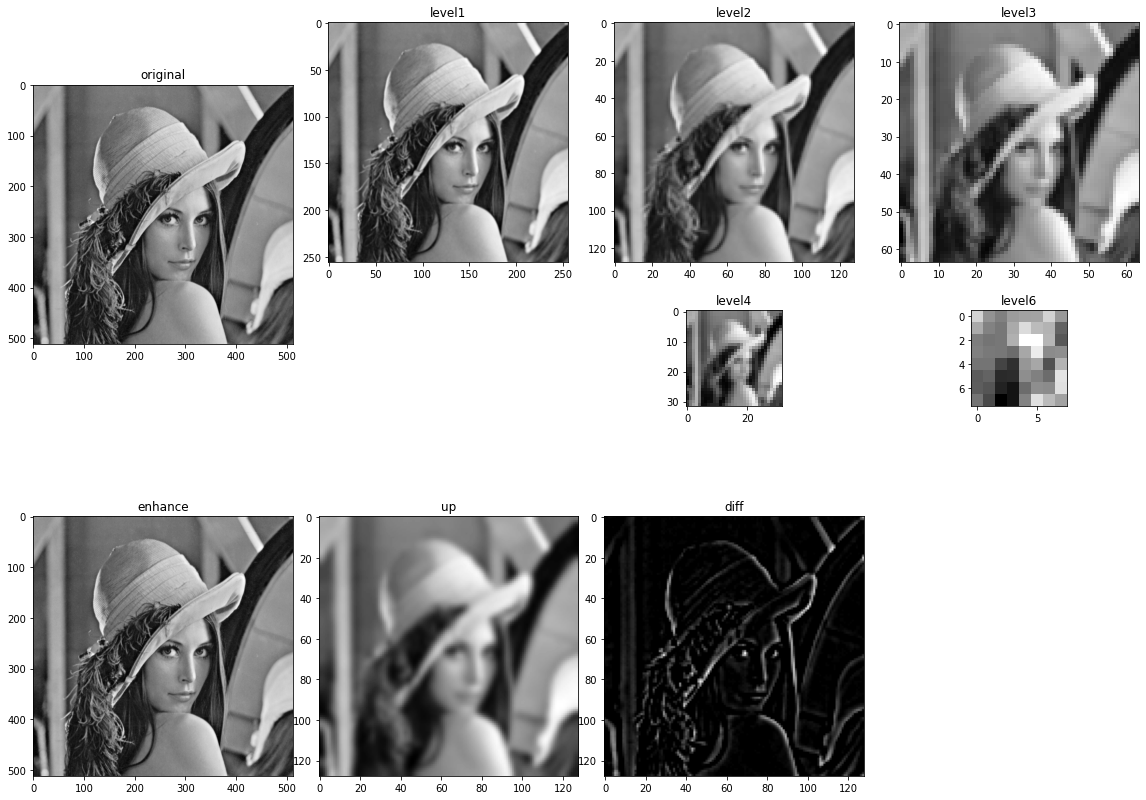

In [196]:
import os
import cv2.cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5, wspace=0.1)
grid_shape=(6,4)

img = cv2.imread(os.path.join(image_root_path, "Lenna.png"))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# =======================================================
# Cropping, 이미지가 너무 커서 자르겠습니다, numpy Slice를 활용
loc=(0,0) # location(loc): 0,3 
# cat_box = [720, 560, 2256, 3120]  # x_min, y_min, x_max, y_max 2048+512 = 2560
# img = img[cat_box[1]:cat_box[3], cat_box[0]:cat_box[2]]  # 고양이 부분 좌표
ax = plt.subplot2grid(grid_shape, loc, rowspan=3)
ax.set_title('original')
ax.imshow(img, cmap="gray")

# level 1
loc = (0,1)
level1_img = cv2.pyrDown(img)
print(level1_img.shape)
ax = plt.subplot2grid(grid_shape, loc, rowspan=2)
ax.set_title('level1')
ax.imshow(level1_img, cmap="gray")

# level 2
loc = (0,2)
level2_img = cv2.pyrDown(level1_img)
print(level2_img.shape)
ax = plt.subplot2grid(grid_shape, loc, rowspan=2)
ax.set_title('level2')
ax.imshow(level2_img, cmap="gray")

# level 3
loc = (0,3)
level3_img = cv2.pyrDown(level2_img)
print(level3_img.shape)
ax = plt.subplot2grid(grid_shape, loc, rowspan=2)
ax.set_title('level3')
ax.imshow(level3_img, cmap="gray")

# level 4
loc = (2,2)
level4_img = cv2.pyrDown(level3_img)
print(level4_img.shape)
ax = plt.subplot2grid(grid_shape, loc)
ax.set_title('level4')
ax.imshow(level4_img, cmap="gray")

# level 5
loc = (2,3)
level5_img = cv2.pyrDown(level4_img)
print(level5_img.shape)
ax = plt.subplot2grid(grid_shape, loc)
ax.set_title('level5')
ax.imshow(level5_img, cmap="gray")

# level 6
loc = (2,3)
level6_img = cv2.pyrDown(level5_img)
print(level6_img.shape)
ax = plt.subplot2grid(grid_shape, loc)
ax.set_title('level6')
ax.imshow(level6_img, cmap="gray")

# up level 3
loc=(3,1)
up_img = cv2.pyrUp(level3_img)
ax = plt.subplot2grid(grid_shape, loc, rowspan=3)
ax.set_title('up')
ax.imshow(up_img, cmap="gray")

# level2 - level3
loc=(3,2)
diff_img = cv2.subtract(level2_img, up_img)
ax = plt.subplot2grid(grid_shape, loc, rowspan=3)
ax.set_title('diff')
ax.imshow(diff_img, cmap="gray")

loc=(3,0)
add_img = cv2.addWeighted(img, 1.0, cv2.resize(diff_img, (img.shape[1], img.shape[0])), 0.5, 0)
ax = plt.subplot2grid(grid_shape, loc, rowspan=3)
ax.set_title('enhance')
ax.imshow(add_img, cmap="gray")